# Near Surface Air Temperature Quantile Notebook
This notebook looks at how the high quantiles for near surface air temperature vary with longwave optical depth ($CO_2$ concentration proxy) on an aquaplanet.

It is the same as `quantile_notebook.ipynb` except that it uses near surface air temperature (temperature at lowest pressure level recorded) rather than surface temperature.

The conclusions remain the same as with that notebook.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.utils.constants import L_v, c_p
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
from scipy.stats import percentileofscore
import numpy_indexed
import warnings
from isca_tools.papers.byrne_2021 import get_delta_temp_quant_theory, get_px, get_quant_ind

2023-05-08 08:37:26,565 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


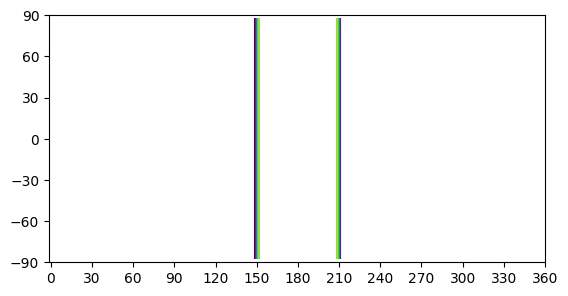

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [4]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2

lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

temp_av = {'ocean': np.zeros(n_exp), 'land': np.zeros(n_exp)}
ds_all = {'ocean': [], 'land': []}    # near surface temperature for each optical depth value
with tqdm(total=n_exp * 2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(pfull=p_surface/100, drop=True)      # get rid of pressure coordinate
        ds_use = ds_use.sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) < lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        if season == 'summer':
            # Get rid of nan values corresponding to the winter hemisphere - half the values are nan
            ds_use = ds_use.sel(lon_lat_time = ds_use.lon_lat_time[np.invert(np.isnan(ds_use.temp))].to_numpy())
        ds_use = ds_use.load()
        for surf in ['land', 'ocean']:
            ds_all[surf] += [ds_use.isel(lon_lat_time=np.where(np.isin(ds_use.lon, np.unique(lon[surf])))[0])]
            temp_av[surf][i] = area_weighting(ds_all[surf][i].temp).mean(dim=['lon_lat_time'])
            pbar.update(1)

100%|██████████| 18/18 [01:32<00:00,  5.13s/it]


In [5]:
# Compute quantile near surface temperature across longitude, latitude and time dimension
# This takes about 3 minutes to run for tropics, 15 minutes for global
quant_all = np.arange(100)
n_quant_all = len(quant_all)
temp_quant_p = {'ocean': np.zeros((n_exp, n_quant_all)), 'land': np.zeros((n_exp, n_quant_all))}
temp_quant_x = {'ocean': np.zeros((n_exp, n_quant_all)), 'land': np.zeros((n_exp, n_quant_all))}
sphum_quant_x = {'ocean': np.zeros((n_exp, n_quant_all)), 'land': np.zeros((n_exp, n_quant_all))}
sphum_quant_p = {'ocean': np.zeros((n_exp, n_quant_all)), 'land': np.zeros((n_exp, n_quant_all))}
mse_quant_x = {'ocean': np.zeros((n_exp, n_quant_all)), 'land': np.zeros((n_exp, n_quant_all))}
with tqdm(total=n_exp * n_quant_all * 2, position=0, leave=True) as pbar:
    for surf in ['ocean', 'land']:
        for i in range(n_exp):
            for j in range(n_quant_all):
                if surf == 'ocean':
                    # only compute p version of quantile for ocean, as needed for theory
                    temp_quant_p[surf][i, j] = ds_all[surf][i].temp.quantile(quant_all[j]/100, dim='lon_lat_time')
                    sphum_quant_p[surf][i, j] = ds_all[surf][i].sphum.quantile(quant_all[j]/100, dim='lon_lat_time')
                use_ind = get_quant_ind(ds_all[surf][i].temp, quant_all[j])
                temp_quant_x[surf][i, j] = ds_all[surf][i].temp[use_ind].mean()
                sphum_quant_x[surf][i, j] = ds_all[surf][i].sphum[use_ind].mean()
                mse_quant_x[surf][i, j] = np.mean(moist_static_energy(ds_all[surf][i].temp[use_ind],
                                                                      ds_all[surf][i].sphum[use_ind],
                                                                      ds_all[surf][i].height[use_ind]))
                pbar.update(1)

100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s]


## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

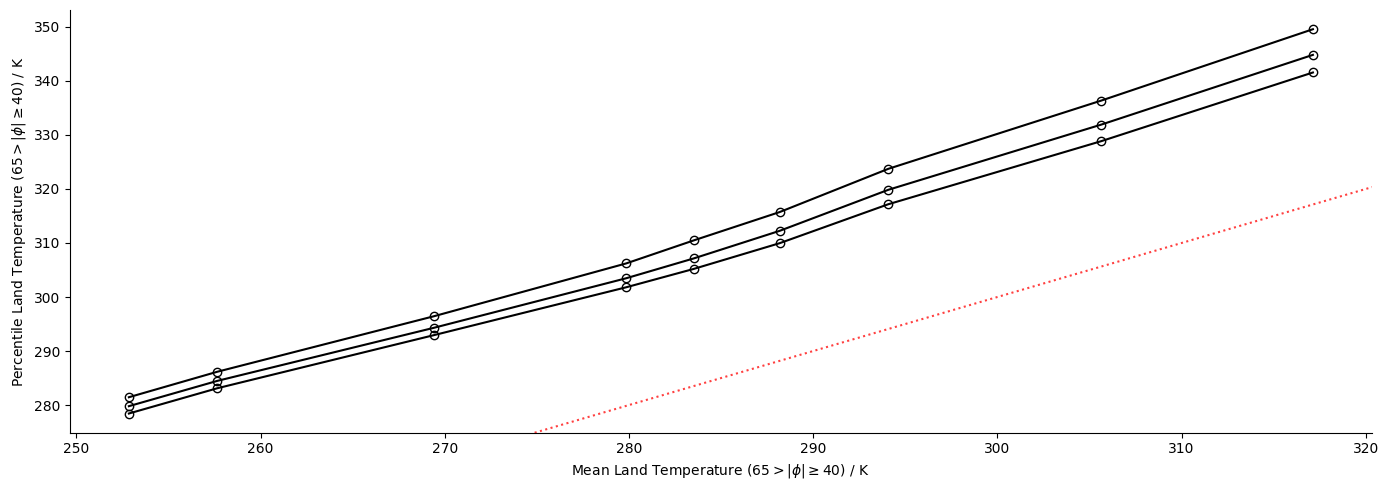

In [6]:
quant_plot = [90, 95, 99]
quant_plot = quant_plot
quant_plot_ind = numpy_indexed.indices(quant_all, quant_plot)
quant_mean_ind = np.where(quant_all==0)[0][0]
n_quant_plot = len(quant_plot)

# RECOMMEND TO use x version as this is what is used in the theory
temp_quant_use = temp_quant_x

# surf_plot = ['ocean', 'land']
surf_plot = ['land']
trend_line_on = False
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

scaling_factor = {'ocean': np.zeros(n_quant_plot), 'land': np.zeros(n_quant_plot)}

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]

fig, ax = plt.subplots(1,len(surf_plot), figsize=(14, 5), sharex=True, sharey=True)
if len(surf_plot) == 1:
    ax = [ax]
for k, surf in enumerate(surf_plot):
    ax[k].spines[['right', 'top']].set_visible(False)
    for j, quant_ind in enumerate(quant_plot_ind):
        fit_func = lambda x, m: temp_quant_use[surf][tau_ref_ind, quant_ind] + m*(x-temp_av[surf][tau_ref_ind])     # Straight line through the ref point
        scaling_factor[surf][j] = scipy.optimize.curve_fit(fit_func, temp_av[surf],
                                                           temp_quant_use[surf][:, quant_ind])[0]
        ax[k].plot(temp_av[surf], temp_quant_use[surf][:, quant_ind], marker='o',
                   label='{}$^{}$ ({:.2f} K/K)'.format(quant_plot[j], '{th}', scaling_factor[surf][j]), color='k', fillstyle='none')
        if trend_line_on:
            # Filled circle for reference simulation
            ax[k].plot(temp_av[surf][tau_ref_ind], temp_quant_use[surf][tau_ref_ind, quant_ind], marker='o', color='k', fillstyle='full')
            if j==n_quant_plot-1:
                label = 'Linear Increase'
            else:
                label = None
            ax[k].plot(temp_av[surf], fit_func(temp_av[surf], scaling_factor[surf][j]), linestyle=':', color='k', alpha=0.3, label=label)
    xlim = ax[k].get_xlim()
    ylim = ax[k].get_ylim()
    ax[k].plot([ax[k].get_ylim()[0], ax[k].get_xlim()[1]],
               [ax[k].get_ylim()[0], ax[k].get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
    if k == len(surf_plot)-1:
        ax[k].set_xlim(xlim)
        ax[k].set_ylim(ylim)
    if trend_line_on:
        ax[k].legend(title='Percentile (Gradient)', frameon=False)
    if season == 'summer':
        ax[k].set_xlabel(f'Mean {surf.capitalize()} Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
        ax[k].set_ylabel(f'Percentile {surf.capitalize()} Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    else:
        ax[k].set_xlabel(f'Mean {surf.capitalize()} Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
        ax[k].set_ylabel(f'Percentile {surf.capitalize()} Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
plt.tight_layout()
if save_fig:
    if trend_line_on:
        file_name = f"{region.lower()}_trend"
    else:
        file_name = f"{region.lower()}_no_trend"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

## Theory for predicting next temperature based on the previous $\kappa$
This adds the theory prediction of temperature averaged above a percentile. The theory can predict the temperature at the next kappa value based on the previous optical depth value.

In [7]:
# get all variables required for theory
temp_mean = {surf: np.asarray([ds_all[surf][i].temp.mean() for i in range(n_exp)]) for surf in ['ocean', 'land']}
sphum_mean = {surf: np.asarray([ds_all[surf][i].sphum.mean() for i in range(n_exp)]) for surf in ['ocean', 'land']}
delta_temp_quant = {surf: np.diff(temp_quant_x[surf], axis=0) for surf in ['ocean', 'land']}
p_x = get_px(ds_all['land'], mse_quant_x['land'], quant_all, True)
if p_x.max()>99:
    warnings.warn(f'Changing {(p_x>99).sum()} values to 99 from over 100')
    p_x = np.clip(p_x, -1, 99)

delta_temp_quant_theory = get_delta_temp_quant_theory(temp_mean['land'], sphum_mean['land'], temp_quant_x['land'], temp_quant_p['ocean'],
                                                      sphum_quant_x['land'], sphum_quant_p['ocean'], quant_all, p_x, p_surface)
delta_temp_quant_theory_const_rh = get_delta_temp_quant_theory(temp_mean['land'], sphum_mean['land'], temp_quant_x['land'],
                                                               temp_quant_p['ocean'], sphum_quant_x['land'],
                                                               sphum_quant_p['ocean'], quant_all, p_x, p_surface, True)

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_18904/1503693151.py:7: UserWarning: Changing 1 values to 99 from over 100
  warnings.warn(f'Changing {(p_x>99).sum()} values to 99 from over 100')


In [8]:
# theory uses simulated temperature at previous kappa as reference to add theory of temp change to.
temp_quant_theory = np.zeros((n_exp, n_quant_all))
temp_quant_theory[0] = temp_quant_x['land'][0]
temp_quant_theory[1:] = temp_quant_x['land'][:-1,:] + delta_temp_quant_theory
# # below is theory relative to mean change
# delta_temp_quant_theory2 = (delta_temp_quant_theory/delta_temp_quant_theory[:, quant_mean_ind:quant_mean_ind+1]) * np.diff(
#     temp_quant_x['land'], axis=0)[:, quant_mean_ind:quant_mean_ind+1]
# temp_quant_theory = temp_quant_x['land'][:-1,:] + delta_temp_quant_theory2

temp_quant_theory_const_rh = np.zeros((n_exp, n_quant_all))
temp_quant_theory_const_rh[0] = temp_quant_x['land'][0]
temp_quant_theory_const_rh[1:] = temp_quant_x['land'][:-1,:] + delta_temp_quant_theory_const_rh

# theory 2 uses theory prediction at previous kappa as reference to add theory of temp change to.
temp_quant_theory2 = np.zeros((n_exp, n_quant_all))
temp_quant_theory2[0] = temp_quant_x['land'][0]
temp_quant_theory_const_rh2 = np.zeros((n_exp, n_quant_all))
temp_quant_theory_const_rh2[0] = temp_quant_x['land'][0]
for i in range(n_exp-1):
    temp_quant_theory2[1+i] = temp_quant_theory2[i] + delta_temp_quant_theory[i]
    temp_quant_theory_const_rh2[1+i] = temp_quant_theory_const_rh2[i] + delta_temp_quant_theory_const_rh[i]

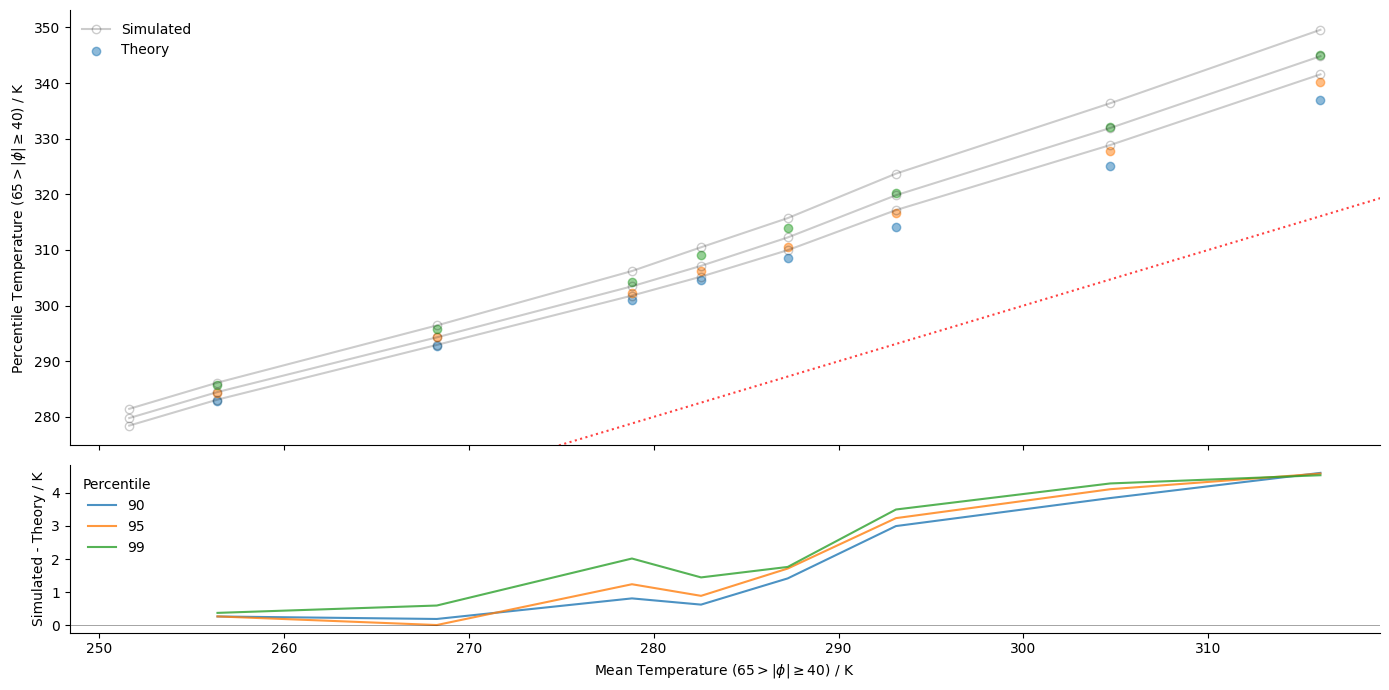

In [16]:
save_fig=True
theory_method = ''
# theory_method = '_const_rh'
fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [2.6, 1]})
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    ax[0].plot(temp_mean['land'], temp_quant_x['land'][:, quant_plot_ind[j]], marker='o', color='k', fillstyle='none', alpha=0.2)
    if theory_method == '_const_rh':
        ax[0].scatter(temp_mean['land'][1:], temp_quant_theory_const_rh[1:, quant_plot_ind[j]], alpha=0.5)
        ax[1].plot(temp_mean['land'][1:], temp_quant_x['land'][1:, quant_plot_ind[j]]-
                   temp_quant_theory_const_rh[1:, quant_plot_ind[j]], label=quant_plot[j], alpha=0.8)
    else:
        ax[0].scatter(temp_mean['land'][1:], temp_quant_theory[1:, quant_plot_ind[j]], alpha=0.5)
        ax[1].plot(temp_mean['land'][1:], temp_quant_x['land'][1:, quant_plot_ind[j]]-
                   temp_quant_theory[1:, quant_plot_ind[j]], label=quant_plot[j], alpha=0.8)
ax[0].legend(['Simulated', 'Theory'], loc='upper left', frameon=False)
ax[1].legend(title='Percentile', loc='upper left', frameon=True, framealpha=1, edgecolor='white')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[1].hlines(0, xlim[0], xlim[1], color='k', alpha=0.5, linewidth=0.5)
ax[0].plot([ax[0].get_ylim()[0], ax[0].get_xlim()[1]], [ax[0].get_ylim()[0], ax[0].get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax[0].set_ylim(ylim)
ax[0].set_xlim(xlim)
if season == 'summer':
    ax[-1].set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax[0].set_ylabel(f'Percentile Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax[-1].set_xlabel(f'Mean Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax[0].set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
ax[1].set_ylabel('Simulated - Theory / K')
plt.tight_layout()
if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/{region.lower()}_theory{theory_method}",dpi=high_dpi if publish_fig else low_dpi)

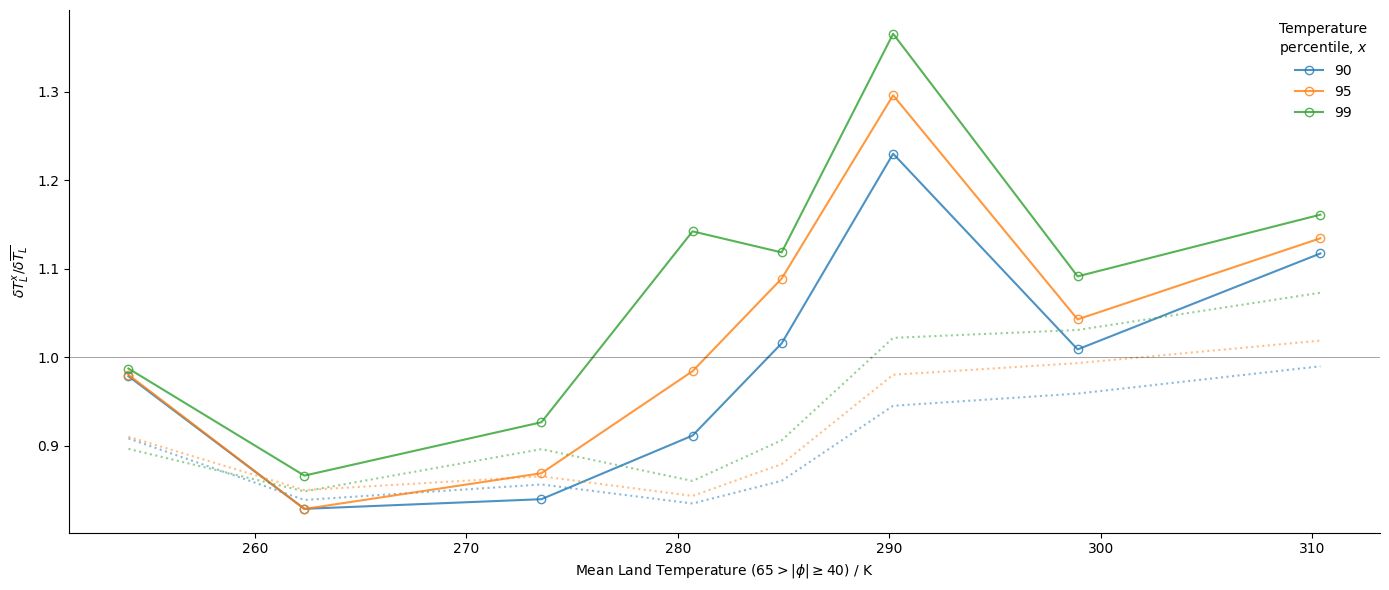

In [17]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_fig=True
theory_method = ''
# theory_method = '_const_rh'
fig, ax = plt.subplots(1,1, figsize=(14, 6))
ax.spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    # for difference between simulations, make x-axis the average between the two mean temperatures
    ax.plot(moving_average(temp_mean['land'], 2),
            delta_temp_quant['land'][:, quant_plot_ind[j]]/delta_temp_quant['land'][:, quant_mean_ind], color=default_colors[j],
            alpha=0.8, marker='o', fillstyle='none', label=quant_plot[j])
    if theory_method == '_const_rh':
        ax.plot(moving_average(temp_mean['land'], 2),
                delta_temp_quant_theory_const_rh[:, quant_plot_ind[j]]/delta_temp_quant_theory_const_rh[:, quant_mean_ind],
                color=default_colors[j], linestyle=':', alpha=0.5)
    else:
        ax.plot(moving_average(temp_mean['land'], 2),
                delta_temp_quant_theory[:, quant_plot_ind[j]]/delta_temp_quant_theory[:, quant_mean_ind],
                color=default_colors[j], linestyle=':', alpha=0.5)
ax.legend(title='Temperature\npercentile, $x$', frameon=False)
xlim = ax.get_xlim()
ax.hlines(1, xlim[0], xlim[1], color='k', alpha=0.5, linewidth=0.5)
ax.set_xlim(xlim)
if season == 'summer':
    ax.set_xlabel(f'Mean Summer Land Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax.set_xlabel(f'Mean Land Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
ax.set_ylabel('$\delta T^x_L/\delta \overline{T_L}$')
plt.tight_layout()
if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/{region.lower()}_amplification_factor{theory_method}",
                dpi=high_dpi if publish_fig else low_dpi)

## Figure 2 of Byrne 2021 - combining $\kappa$
The gradients in the above plot indicate the scaling factors shown in the bottom plot of Byrne 2021 figure 2, but combine all $\kappa$ values indicated by `scaling_factor_kappa_use`. So I plot the gradients versus percentile, $x$, here to replicate the figure.

I include the option for two different quantiles. In Byrne 2021, it is the temperatures averaged over a given percentile - I refer to this as `temp_quant_x`. The other option is using the actual percentile, given here as `temp_quant_p`.

For the mean below, I don't use area weighting, whereas I do above, hence the difference. I don't use it below so that `temp_quant_x` plot always shows a scaling factor of $1$ for $x=0$.

To see if the scaling factor is different for warmer vs colder climates, I compute the gradients using a subset of $\kappa$ values. For colder climates, I use $\kappa=0.6, 1, 1.2, 1.5$ and force the line through $\kappa=1.5$. For warmer climates, I use $\kappa=1.5, 2, 3.5, 6$ and force the line through $\kappa=1.5$. It may make more sense to force the line through the same $\kappa$ values for both though. The solid line includes all $\kappa$ and is forced through $\kappa = 1.5$.

In [11]:
quant_type_use = 'x'
temp_quant_use = temp_quant_x if quant_type_use == 'x' else temp_quant_p
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]
n_sf = len(sf_tau_use)
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
sf_temp_mean = {surf: temp_quant_x[surf][:, 0] for surf in ['ocean', 'land']}
scaling_factor = {'ocean': np.zeros((n_sf, n_quant_all)), 'land': np.zeros((n_sf, n_quant_all))}
scaling_factor_theory = np.zeros(n_quant_all)
scaling_factor_theory_const_rh = np.zeros(n_quant_all)
scaling_factor_theory2 = np.zeros(n_quant_all)
scaling_factor_theory_const_rh2 = np.zeros(n_quant_all)

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw==sf_tau_ref[i])[0]
    for k, surf in enumerate(['ocean', 'land']):
        for j in range(n_quant_all):
            # Straight line through the ref point
            fit_func = lambda x, m: temp_quant_use[surf][sf_tau_ref_ind, j] + m*(x-sf_temp_mean[surf][sf_tau_ref_ind])
            scaling_factor[surf][i, j] = scipy.optimize.curve_fit(fit_func, sf_temp_mean[surf][sf_tau_use[i]],
                                                               temp_quant_use[surf][sf_tau_use[i], j])[0]
            if i == 0 and surf == 'land':
                fit_func = lambda x, m: temp_quant_theory[sf_tau_ref_ind, j] + \
                                        m*(x-temp_quant_theory[sf_tau_ref_ind, quant_mean_ind])
                scaling_factor_theory[j] = scipy.optimize.curve_fit(fit_func, temp_quant_theory[sf_tau_use[i], quant_mean_ind],
                                                                    temp_quant_theory[sf_tau_use[i], j])[0]
                fit_func = lambda x, m: temp_quant_theory_const_rh[sf_tau_ref_ind, j] + \
                            m*(x-temp_quant_theory_const_rh[sf_tau_ref_ind, quant_mean_ind])
                scaling_factor_theory_const_rh[j] = scipy.optimize.curve_fit(fit_func,
                                                                             temp_quant_theory_const_rh[sf_tau_use[i], quant_mean_ind],
                                                                             temp_quant_theory_const_rh[sf_tau_use[i], j])[0]

                fit_func = lambda x, m: temp_quant_theory2[sf_tau_ref_ind, j] + \
                        m*(x-temp_quant_theory2[sf_tau_ref_ind, quant_mean_ind])
                scaling_factor_theory2[j] = scipy.optimize.curve_fit(fit_func, temp_quant_theory2[sf_tau_use[i], quant_mean_ind],
                                                                    temp_quant_theory2[sf_tau_use[i], j])[0]
                fit_func = lambda x, m: temp_quant_theory_const_rh2[sf_tau_ref_ind, j] + \
                            m*(x-temp_quant_theory_const_rh2[sf_tau_ref_ind, quant_mean_ind])
                scaling_factor_theory_const_rh2[j] = scipy.optimize.curve_fit(fit_func,
                                                                             temp_quant_theory_const_rh2[sf_tau_use[i], quant_mean_ind],
                                                                             temp_quant_theory_const_rh2[sf_tau_use[i], j])[0]

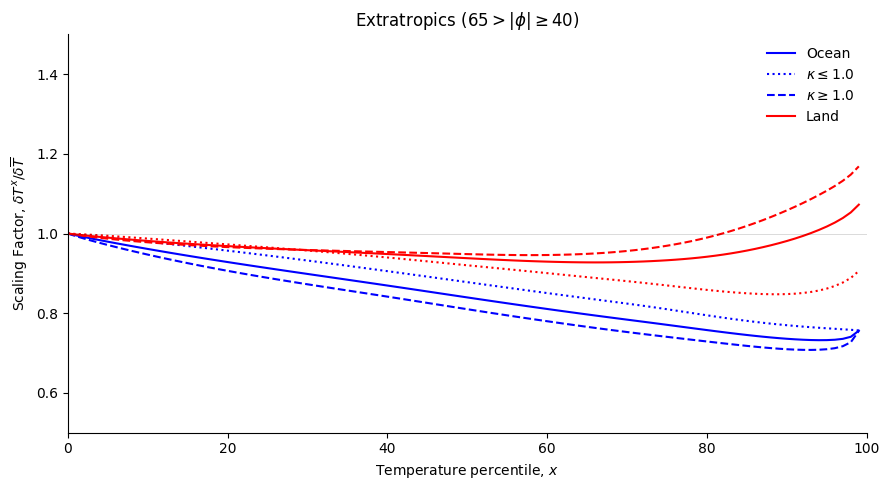

In [12]:
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
surf_colors = {'ocean': 'b', 'land': 'r'}
fig, ax = plt.subplots(1,1, figsize=(9, 5))
ax.spines[['right', 'top']].set_visible(False)
for surf in ['ocean', 'land']:
    ax.plot(quant_all, scaling_factor[surf][0], color=surf_colors[surf])
    ax.plot(quant_all, scaling_factor[surf][1], color=surf_colors[surf], linestyle=':')
    ax.plot(quant_all, scaling_factor[surf][2], color=surf_colors[surf], linestyle='--')
ax.hlines(1, 0, 100, linewidth=0.5, alpha=0.2, color='k')
ax.legend(['Ocean', f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$', f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$', 'Land'],
          frameon=False)
ax.set_xlim(0,100)
if quant_type_use == 'x':
    ax.set_ylim(0.5,1.5)
else:
    ax.set_ylim(0.5,2.5)
ax.set_xlabel('Temperature percentile, $x$')
if quant_type_use == 'x':
    ax.set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
else:
    ax.set_ylabel('Scaling Factor, $\delta T(x)/ \delta \\overline{T}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig:
    file_name = f"scaling_factor_{region.lower()}_{quant_type_use}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

The solid red line below is the same as that above. The black lines show the theoretical prediction for the red line, combining all kappa values.

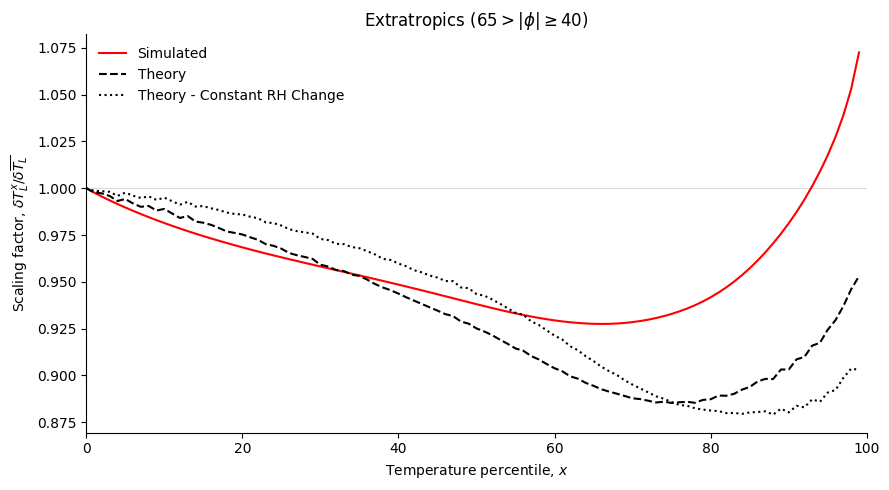

In [18]:
save_fig = True
# if publishing figure, use high dpi
publish_fig = True
scale_method = 2
fig, ax = plt.subplots(1,1, figsize=(9, 5))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quant_all, scaling_factor['land'][0], color='r', label='Simulated')
if scale_method == 1:
    ax.plot(quant_all, scaling_factor_theory, color='k', linestyle='--',
            label=f'Theory')
    ax.plot(quant_all, scaling_factor_theory_const_rh, color='k', linestyle=':',
            label= f'Theory - Constant RH Change')
else:
    ax.plot(quant_all, scaling_factor_theory2, color='k', linestyle='--',
            label=f'Theory')
    ax.plot(quant_all, scaling_factor_theory_const_rh2, color='k', linestyle=':',
            label= f'Theory - Constant RH Change')
ax.hlines(1, 0, 100, linewidth=0.5, alpha=0.2, color='k')
ax.legend(frameon=False)
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T^x_L/\delta \overline{T_L}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    if scale_method != 1:
        file_name += '_theory_prev_iter'
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

## Figure 2 of Byrne 2021 - all $\kappa$ separately
Below I plot the temperature change between simulations of adjacent $\kappa$ values as a function of temperature quantile.
I then compare this to the change in the mean temperature, through the scaling factor.

Note that this plot shows considers the average of temperatures above a given percentile, whereas the above plot considers the actual temperature corresponding to given percentiles.

### Tropics
For the colder simulations, $\kappa \leq 1.5$, there seems to be a trend for the hottest days to warm less than the mean, as indicated by the scale factor being less than 1.
For the warmer simulations, we see that the hottest days warm the most.

If I use all days, rather than just summer, the scaling factor is significantly smaller and below 1 for all simulations.

In [14]:
# Get change for each quantile between a warmed world and a reference world
# quantiles_all = np.arange(100)
# temp_all_quant = {'ocean': np.zeros((n_exp, len(quantiles_all))), 'land': np.zeros((n_exp, len(quantiles_all)))}
# with tqdm(total=n_exp * len(quantiles_all) * 2, position=0, leave=True) as pbar:
#     for surf in ['ocean', 'land']:
#         for i in range(n_exp):
#             for j in range(len(quantiles_all)):
#                 quant_thresh = ds_all[surf][i].temp.quantile(quantiles_all[j]/100, dim='lon_lat_time')
#                 quant_ind = np.where(ds_all[surf][i].temp > quant_thresh)[0]
#                 temp_all_quant[surf][i, j] = ds_all[surf][i].temp[quant_ind].mean(dim='lon_lat_time')
#                 pbar.update(1)

In [15]:
# warm_colors = plt.cm.jet(np.linspace(0,1,n_exp-1))
# fig, ax = plt.subplots(2,2, figsize=(14, 8), sharex=True, sharey='row')
# for k, surf in enumerate(['ocean', 'land']):
#     for i in range(n_exp-1):
#         ax[0, k].plot(quantiles_all, temp_all_quant[surf][i+1]-temp_all_quant[surf][i],
#                    color=warm_colors[i], label=f'$\kappa={tau_lw[i]}$')
#         ax[1, k].plot(quantiles_all, (temp_all_quant[surf][i+1]-temp_all_quant[surf][i]
#                                       )/(temp_all_quant[surf][i+1] - temp_all_quant[surf][i])[0],
#                    color=warm_colors[i])
#     ax[1, k].hlines(1, 0, 100, color='k', alpha=0.2, linestyle=':')
#     ax[0, k].set_title(surf)
# ax[0, 0].set_xlim(0, 100)
# ax[0, 0].set_ylabel('Temperature Change / K')
# ax[0, 0].legend()
# ax[1, 0].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
# if season == 'summer':
#     fig.supxlabel('Summer Temperature Percentile, $x$')
# else:
#     fig.supxlabel('Temperature Percentile, $x$')
# fig.suptitle(f'{region} (${lat_max}> |\phi| > {lat_min}$)')
# plt.tight_layout();